# Athletes Clustering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

2025-03-26 22:01:42.713496: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
np.random.seed(42)

In [4]:
# read data
file_path = 'data/raw_data.csv'
df = pd.read_csv(file_path)

In [5]:
# general data statistics
print("Data Shape: ", df.shape)
print("Data Shape: ", df.dtypes)
print(df.head())
print("NaN Count: ", df.isna().sum())

Data Shape:  (5811, 54)
Data Shape:  User ID              object
Phone                 int64
Gender               object
Age                   int64
Weight                int64
Height                int64
Date/Time            object
Tiredness           float64
Calm                float64
Nutrition           float64
Hydration           float64
Performance         float64
Concentrate         float64
Happy               float64
Determined          float64
Excited             float64
Loving              float64
Motivated           float64
Powerful            float64
Helpful             float64
Lively              float64
Peaceful            float64
Proud               float64
Optimistic          float64
Valued              float64
Content             float64
Hopeful             float64
Confident           float64
Relieved            float64
Annoyed             float64
Nervous             float64
Overwhelmed         float64
Irritated           float64
Anxious             float64
Afraid     

In [6]:
# data labels
num_cols = df.select_dtypes(include=['number']).columns.tolist() # numeric features only

# basic stats
print(df[num_cols].describe())

              Phone          Age       Weight       Height    Tiredness  \
count  5.811000e+03  5811.000000  5811.000000  5811.000000  5443.000000   
mean   4.292861e+11    37.977112    70.856307   166.417484    57.404005   
std    8.626252e+10    16.029018    18.580443    14.901750    22.133887   
min    1.203707e+10    16.000000     1.000000     1.000000     1.000000   
25%    4.474691e+11    21.000000    56.000000   160.000000    39.000000   
50%    4.478218e+11    39.000000    66.000000   167.000000    61.000000   
75%    4.479641e+11    56.000000    82.000000   175.000000    74.000000   
max    9.170270e+11    58.000000   165.000000   199.000000   100.000000   

              Calm    Nutrition    Hydration  Performance  Concentrate  ...  \
count  5457.000000  5437.000000  5437.000000  5067.000000  1598.000000  ...   
mean     61.795675    65.070995    56.734412    62.986185    68.592616  ...   
std      20.128651    21.540824    20.630142    17.885824    22.188042  ...   
min     

In [7]:
print(df.columns)

Index(['User ID', 'Phone', 'Gender', 'Age', 'Weight', 'Height', 'Date/Time',
       'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance',
       'Concentrate', 'Happy', 'Determined', 'Excited', 'Loving', 'Motivated',
       'Powerful', 'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic',
       'Valued', 'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed',
       'Nervous', 'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry',
       'Worried', 'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused',
       'Embarrassed', 'Sad', 'Actions', 'With', 'Reflections', 'Steps',
       'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn',
       'Calories Intake'],
      dtype='object')


In [8]:
# emotions to be predicted (NaN values)
emotion_targets = ['Happy', 'Determined', 'Excited', 'Loving', 'Motivated', 'Powerful',
                   'Helpful', 'Lively', 'Peaceful', 'Proud', 'Optimistic', 'Valued',
                   'Content', 'Hopeful', 'Confident', 'Relieved', 'Annoyed', 'Nervous',
                   'Overwhelmed', 'Irritated', 'Anxious', 'Afraid', 'Angry', 'Worried',
                   'Bored', 'Lonely', 'Weary', 'Disappointed', 'Confused', 'Embarrassed', 'Sad']

# feauters used to predict emotions
emotion_predictors = ['Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance', 'Concentrate',
              'Actions', 'With', 'Reflections', 'Steps', 'Sleep', 'HRV', 'Sleep Heart Rate',
              'Glucose', 'Callories Burn', 'Calories Intake']

# feauters used to predict emotions
wearable_data = ['Concentrate', 'Steps', 'Sleep', 'HRV', 'Sleep Heart Rate', 'Glucose', 'Callories Burn', 'Calories Intake']

# general user stats to plot in histigrams
general_data = ['Gender', 'Age', 'Weight', 'Height', 'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance', 'Concentrate']

# most frequent predictors
pred_freq = ['Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance']

## Data Preprocessing
- Convert data to same format, e.g. gender contains both "Woman" and "woman"
- Plot histograms and handle missing values (NaN)

In [9]:
# Preprocess data
# Convert the 'Gender' column to lowercase
df['Gender'] = df['Gender'].str.lower()

In [10]:
# Initial percentage of NaN values
nan_percentage_per_row = df.isna().mean() * 100

# Display the results
print(nan_percentage_per_row)

User ID              0.000000
Phone                0.000000
Gender               0.000000
Age                  0.000000
Weight               0.000000
Height               0.000000
Date/Time            0.000000
Tiredness            6.332817
Calm                 6.091895
Nutrition            6.436070
Hydration            6.436070
Performance         12.803304
Concentrate         72.500430
Happy               76.837033
Determined          87.385992
Excited             90.930993
Loving              96.196868
Motivated           83.049389
Powerful            96.713130
Helpful             97.298227
Lively              96.988470
Peaceful            85.493030
Proud               91.774221
Optimistic          91.808639
Valued              95.646188
Content             85.837205
Hopeful             94.321115
Confident           96.179659
Relieved            96.454999
Annoyed             96.833591
Nervous             91.843056
Overwhelmed         95.405266
Irritated           97.573567
Anxious   

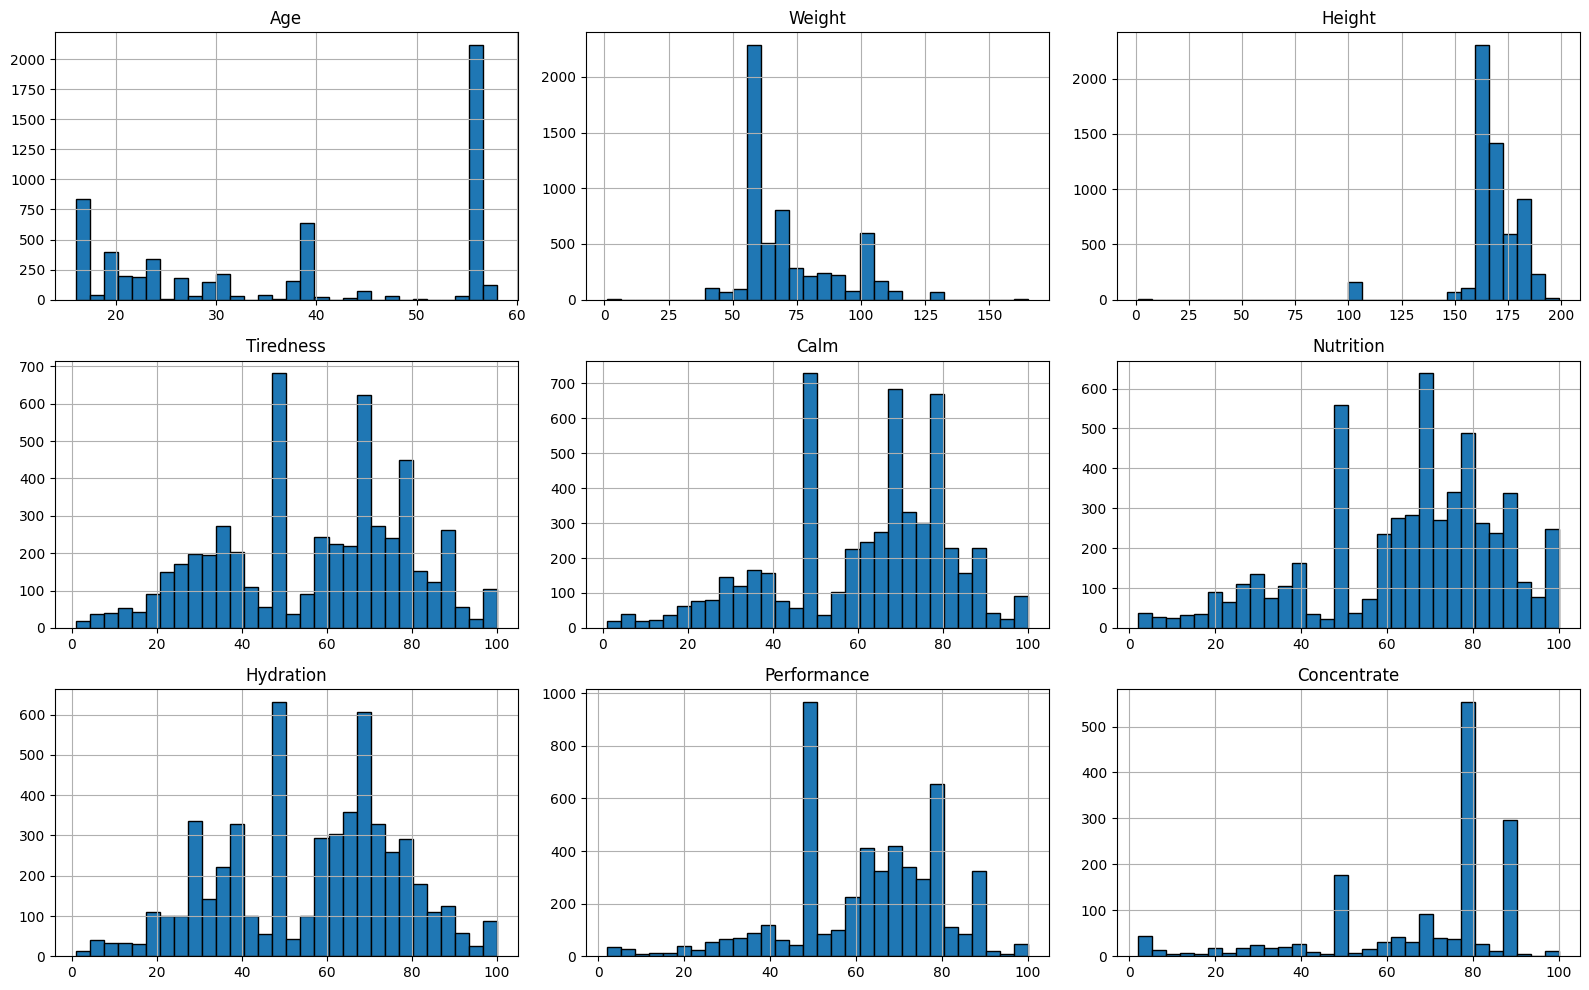

In [11]:
# plot distributions of general statistcs
df[general_data].hist(bins=30, figsize=(16, 10), edgecolor='black')
plt.tight_layout()
plt.show()

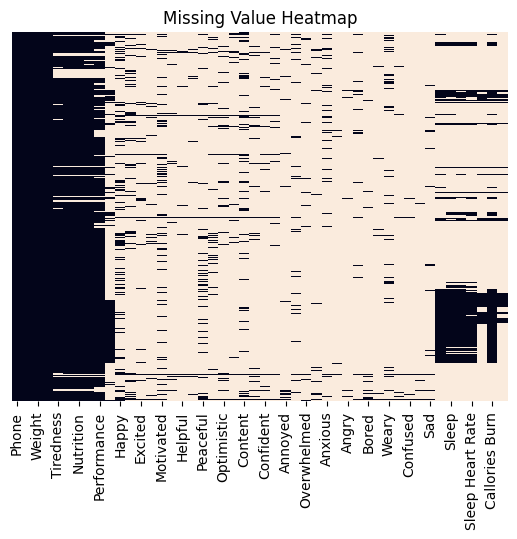

In [12]:
# Visualize missing data
sns.heatmap(df[num_cols].isna(), cbar=False, yticklabels=False)
plt.title("Missing Value Heatmap")
plt.show()

In [13]:
# currently dropping categorical data
numerical_data = df.drop(['User ID', 'Gender', 'Date/Time', 'Actions', 'With', 'Reflections'], axis=1)
print(numerical_data.shape)

(5811, 48)


## Correlation Matrix
Plot the correlation factors of all the numerial features of the dataset

Correlation Matrix Shape:  (48, 48)


<Axes: >

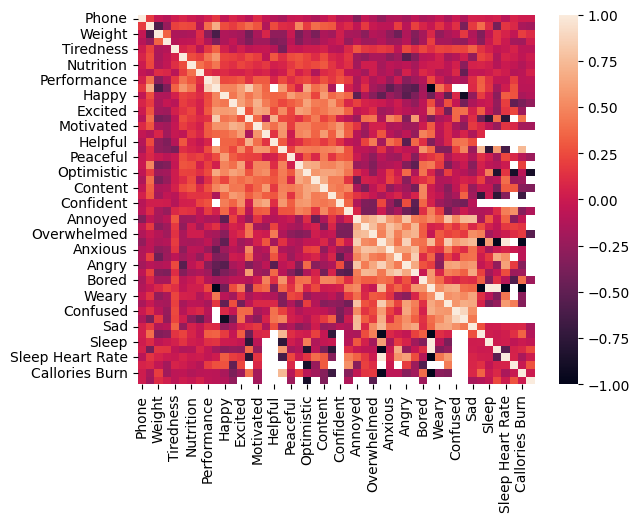

In [14]:
corr_matrix = numerical_data.corr()
print("Correlation Matrix Shape: ", corr_matrix.shape)
sns.heatmap(corr_matrix)

In [15]:
# example: print correlation weights of single feature "Happy"
corr_matrix["Happy"]

Phone              -0.054475
Age                 0.252047
Weight             -0.128482
Height             -0.137568
Tiredness           0.039504
Calm                0.216165
Nutrition           0.175236
Hydration           0.105567
Performance         0.239898
Concentrate         0.485426
Happy               1.000000
Determined          0.429132
Excited             0.588934
Loving              0.421649
Motivated           0.544338
Powerful            0.378310
Helpful             0.346508
Lively              0.364073
Peaceful            0.608412
Proud               0.478563
Optimistic          0.501884
Valued              0.219449
Content             0.599863
Hopeful             0.371845
Confident           0.455795
Relieved            0.366788
Annoyed            -0.508140
Nervous            -0.127262
Overwhelmed        -0.306189
Irritated          -0.494266
Anxious            -0.224274
Afraid             -0.313642
Angry              -0.541123
Worried            -0.361799
Bored         

## Clusters with Correlations

### Approach 1: hierarchical clustering - dendrogram

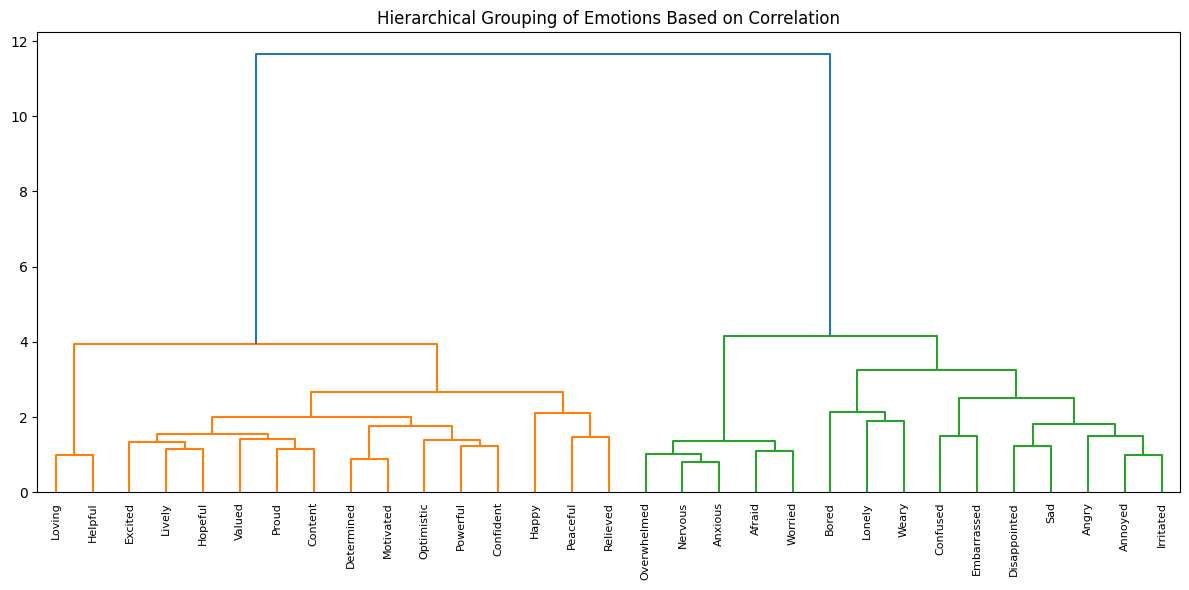

,Emotion,Group
0,Happy,1
1,Determined,1
2,Excited,1
3,Loving,1
4,Motivated,1
5,Powerful,1
6,Helpful,1
7,Lively,1
8,Peaceful,1
9,Proud,1


In [16]:
# correlation matrix for emotions to determine which ones influence each other
emotion_corr = df[emotion_targets].corr(method='pearson')

# hierarchical clustering
Z = linkage(emotion_corr, method='ward')

# plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=emotion_corr.columns, leaf_rotation=90)
plt.title("Hierarchical Grouping of Emotions Based on Correlation")
plt.tight_layout()
plt.show()

# assign emotion clusters (2 groups)
emotion_cluster_labels = fcluster(Z, t=2, criterion='maxclust')

# map emotions to their group
emotion_groups = pd.DataFrame({
    "Emotion": emotion_corr.columns,
    "Group": emotion_cluster_labels
}).sort_values("Group")

emotion_groups.head(30)

## Grouping Emotions

### Approach 2: 
- Identify groups of similar emotions from previous Hierarchical Clustering based on correlation (CAN BE IMPROVED TO SOMETHING ELSE TO HAVE BETTER CLUSTERS)
- Aggregate columns of emotions that belong to the same group by calculating them mean (this way we reducte the number of NaN)
- Generate text embeddings
- Predict probability of emotion groups based on text embeddings

#### Step 1 - 2:
group emotions that belong to the same gorup by calculating their mean

In [17]:
emotions_labels = ['Positive Emotion', 'Negative Emotion']
group_id_to_label = {
    1: 'Positive Emotion',
    2: 'Negative Emotion'
}

# define emotion mappings from previous plot
emotion_dict = dict(zip(emotion_groups['Emotion'], emotion_groups['Group']))

print("Initial Dataframe Shape: ", df.shape)

# Map emotional features to group (ALL NaN!!!)
df_target = df[emotion_targets].apply(lambda x: x.map(emotion_dict), axis=1)

target = list(emotion_groups.keys())

clustered_data = pd.DataFrame(index=df.index)

# iterate over the emotion groups and calculate the aggregated value (mean/median) for each group
for group in set(emotion_dict.values()):
    # Get features belonging to the current group
    cluster_features = [emotion for emotion, cluster_id in emotion_dict.items() if cluster_id == group]
    
    # Subset the dataframe to include only the relevant group features
    cluster_data = df[cluster_features]
    
    # Aggregate the values (e.g., mean) for the features in this group
    # Use mean for non-NaN values in each row
    cluster_aggregated = cluster_data.mean(axis=1, skipna=True)
    
    # Assign the aggregated value to the clustered_data DataFrame
    label = group_id_to_label.get(group, f"Emotion_{group}")  # fallback to default name
    clustered_data[label] = cluster_aggregated

Initial Dataframe Shape:  (5811, 54)


In [18]:
df_grouped = df.copy()
df_grouped = df_grouped.drop(columns=emotion_targets)
df_grouped = pd.concat([df_grouped, clustered_data], axis=1)
print("Dataframe Shape after Grouping Emotions: ", df_grouped.shape)

Dataframe Shape after Grouping Emotions:  (5811, 25)


In [19]:
df_grouped.head()

,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Reflections,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake,Positive Emotion,Negative Emotion
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T08:24:41.507Z,50.0,50.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,NaN
2,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T18:39:49.540Z,100.0,100.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN


In [20]:
print('Percentage of NaN over whole Dataset (before grouping): ', df.isna().mean().mean() * 100, "%")
print('Percentage of NaN over whole Dataset (after grouping): ', df_grouped.isna().mean().mean() * 100, "%")
df_grouped.isna().mean() * 100

Percentage of NaN over whole Dataset (before grouping):  68.23616767688357 %
Percentage of NaN over whole Dataset (after grouping):  35.213904663569096 %


User ID              0.000000
Phone                0.000000
Gender               0.000000
Age                  0.000000
Weight               0.000000
Height               0.000000
Date/Time            0.000000
Tiredness            6.332817
Calm                 6.091895
Nutrition            6.436070
Hydration            6.436070
Performance         12.803304
Concentrate         72.500430
Actions             12.786095
With                19.377044
Reflections         91.137498
Steps               71.674411
Sleep               73.429702
HRV                 72.913440
Sleep Heart Rate    75.580795
Glucose             88.091551
Callories Burn      71.054896
Calories Intake     89.605920
Positive Emotion    35.811392
Negative Emotion    68.284288
dtype: float64

<Axes: >

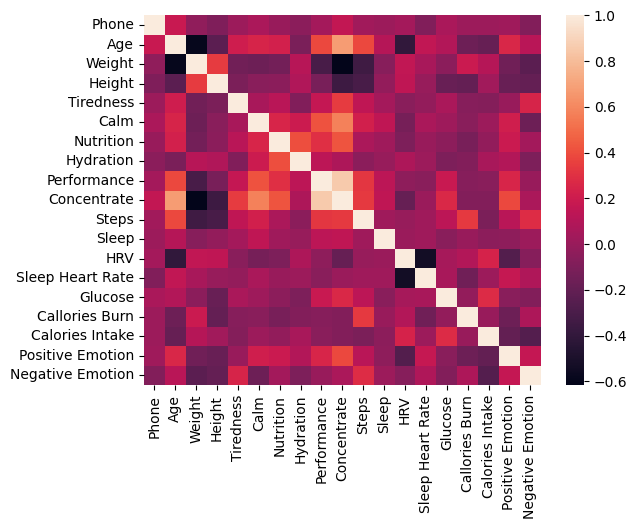

In [21]:
# drop text data for now to compute correlation of numerical data
corr_filled = df_grouped.drop(['User ID', 'Gender', 'Date/Time', 'Actions', 'With', 'Reflections'], axis=1).corr()
corr_filled.shape
sns.heatmap(corr_filled)

## Text Processing

#### Step 3:
generate embeddings from text, currently using TF-IDF  but can be improved to pre-trained embeddings

### Statistics of Text Data
To understand whether it can be used to predict missing emotions of users

In [22]:
ref_data = df.shape[0] - df['Reflections'].isna().sum()
print('Number of Available Reflections: ', ref_data)
print('Percentage of Data: ', ref_data/df.shape[0]*100, "%")

actions_data = df.shape[0] - df['Actions'].isna().sum()
print('Number of Available Actions: ',actions_data)
print('Percentage of Data: ', actions_data/df.shape[0]*100, "%")

with_data = df.shape[0] - df['With'].isna().sum()
print('Number of Available With: ', with_data)
print('Percentage of Data: ', with_data/df.shape[0]*100, "%")

Number of Available Reflections:  515
Percentage of Data:  8.862502151092755 %
Number of Available Actions:  5068
Percentage of Data:  87.2139046635691 %
Number of Available With:  4685
Percentage of Data:  80.62295646188264 %


In [23]:
# fill empty text with unknown token
df_grouped['Actions'] = df_grouped['Actions'].fillna('Unknown')
df_grouped['With'] = df_grouped['With'].fillna('Unknown')
df_grouped['Reflections'] = df_grouped['Reflections'].fillna('Unknown')

In [24]:
# Combine all categorical columns into a single "text" column for vectorization
df_grouped['Text'] = df_grouped['Actions'] + ' ' + df_grouped['With'] + ' ' + df_grouped['Reflections']
df_grouped = df_grouped.drop(columns=['Actions', 'With', 'Reflections'])

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for efficiency

# Fit and transform the text data
X_text = tfidf.fit_transform(df_grouped['Text'])

# Convert the sparse matrix to a dense matrix if needed (optional)
X_text_dense = X_text.toarray()

In [25]:
print(df_grouped.shape)
print("Percentage of NaN over whole Dataset (after text vectorization):", df_grouped.isna().mean().mean() * 100, "%")
df_grouped.isna().mean() * 100

(5811, 23)
Percentage of NaN over whole Dataset (after text vectorization): 32.915086081120506 %


User ID              0.000000
Phone                0.000000
Gender               0.000000
Age                  0.000000
Weight               0.000000
Height               0.000000
Date/Time            0.000000
Tiredness            6.332817
Calm                 6.091895
Nutrition            6.436070
Hydration            6.436070
Performance         12.803304
Concentrate         72.500430
Steps               71.674411
Sleep               73.429702
HRV                 72.913440
Sleep Heart Rate    75.580795
Glucose             88.091551
Callories Burn      71.054896
Calories Intake     89.605920
Positive Emotion    35.811392
Negative Emotion    68.284288
Text                 0.000000
dtype: float64

In [26]:
# NOTE: here i'm counting how many athletes have no emotion data!!
# there is no patient that doesn't have no emotion data AND no text data --> good because we can use the text to train a model on the clusters and then make predictions of the remaining patients that have no emotions 
no_cluster_count = (df_grouped['Positive Emotion'].isna() & df_grouped['Negative Emotion'].isna()).sum()
print('Count of People with no Emotions: ', no_cluster_count)
print(no_cluster_count/df_grouped.shape[0]*100, "%")

Count of People with no Emotions:  1367
23.524350369987953 %


In [27]:
no_text_count = (df_grouped['Text'] == 'Unknown Unknown Unknown').sum()
print('Count of People with no Text ', no_text_count)
print(no_text_count/df_grouped.shape[0]*100, "%")

Count of People with no Text  503
8.655997246601274 %


In [28]:
# Transform group values into probabilities summing to 100 (assign lower probabilities to NaN values to reach 100)
# Could be made more balanced ?
def fill_na_with_probabilities(row):
    # emotion groups with NaN values
    nan_indices = row.isna()
    
    # sum of the available amotions
    available_sum = row.dropna().sum()
    
    # if the available sum is already 100, we don't need to change anything
    if available_sum == 100:
        return row
    
    # calculate the remaining sum to reach 100
    remaining_sum = 100 - available_sum
    
    # count the number of NaN values in the row
    num_missing = nan_indices.sum()

    if num_missing > 0:
        # Handle the case where some NaN values exist
        if available_sum < 100:
            # Distribute the remaining sum equally among the NaN clusters
            remaining_value = remaining_sum / num_missing
            row[nan_indices] = remaining_value
        else:
            # If available sum is larger than 100, make sure the NaNs get 0 or some other logic
            row[nan_indices] = 0
    
    return row

In [29]:
print("Dataframe Shape: ", df_grouped.shape)
# Remove rows with missing text (or if text is "Unknown Unknown Unknown")
df_grouped = df_grouped[df_grouped['Text'] != 'Unknown Unknown Unknown']
print("Dataframe Shape (after dropping users with no text): ", df_grouped.shape)

Dataframe Shape:  (5811, 23)
Dataframe Shape (after dropping users with no text):  (5308, 23)


In [30]:
# filter out rows with ALL NaN values in the target columns
df_train = df_grouped.dropna(subset=emotions_labels, how='all')
df_test = df_grouped[df_grouped[emotions_labels].isna().all(axis=1)]
print("Train Data Shape: ", df_train.shape)
print("Test Data Shape: ", df_test.shape)

# fill it groups with distribution over all emotions groups
df_train[emotions_labels] = df_train[emotions_labels].apply(fill_na_with_probabilities, axis=1).fillna(0)
df_train.head()

Train Data Shape:  (4282, 23)
Test Data Shape:  (1026, 23)


/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_38883/1552341569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[emotions_labels] = df_train[emotions_labels].apply(fill_na_with_probabilities, axis=1).fillna(0)


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake,Positive Emotion,Negative Emotion,Text
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Travel Unknown Unknown
5,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-27T20:53:41.166Z,85.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Sleep Family Unknown
6,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-31T14:00:07.220Z,1.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Travel Myself Unknown
7,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T12:29:41.854Z,16.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.333333,46.666667,Work Myself Unknown
8,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T19:55:09.233Z,12.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.500000,34.500000,Work Myself Unknown


In [31]:
# Text features (use TF-IDF to convert text into numerical vectors)
# TODO: improve by using pre-trained embeddings --> WORD2VEC EMBEDDINGS!!!! (or others)
vectorizer = TfidfVectorizer(max_features=400)                  # Adjust max_features as needed (400 is the size of the generated emebdding per word)
X = vectorizer.fit_transform(df_train['Text']).toarray()
print("X Shape: ", X.shape)

# target y = emotions values for each group ([0 - 100])
y = df_train[emotions_labels]
print("y Shape: ", y.shape)
y.values

X Shape:  (4282, 400)
y Shape:  (4282, 2)


array([[50., 50.],
       [50., 50.],
       [50., 50.],
       ...,
       [40., 60.],
       [60., 63.],
       [78., 22.]])

In [32]:
y_val = y.values  # Target probabilities

# Normalize the target probabilities by dividing by 100 (percentage [0,0 - 1,0])
# Normalize so that probabilities sum to 1
y_train = y_val / 100  
y_train

array([[0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       ...,
       [0.4 , 0.6 ],
       [0.6 , 0.63],
       [0.78, 0.22]])

## Wearable Data Analysis

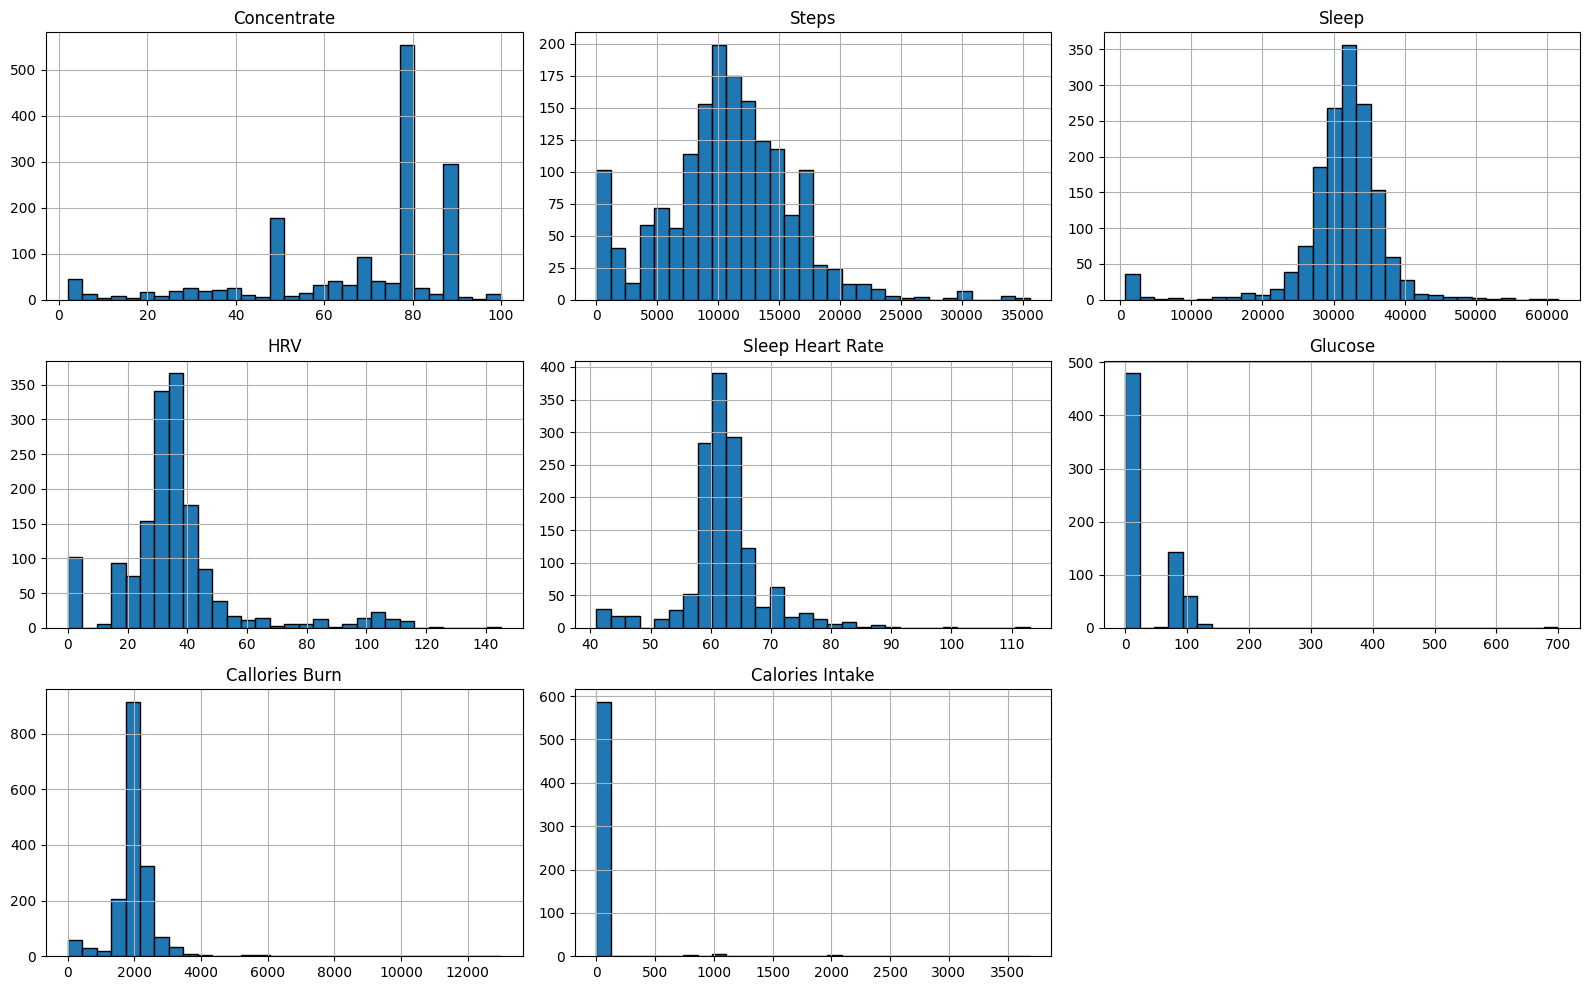

In [33]:
# plot distributions of general statistcs
df[wearable_data].hist(bins=30, figsize=(16, 10), edgecolor='black')
plt.tight_layout()
plt.show()

In [34]:
df_subset = df[['User ID'] + wearable_data]

# Filter rows where *any* wearable data is not NaN
non_empty_rows = df_subset[wearable_data].notna().any(axis=1)
users_with_data = df_subset.loc[non_empty_rows, 'User ID']
num_users = users_with_data.nunique()                           # Count unique User IDs

print(f"Number of unique users with at least one wearable value: {num_users}")

Number of unique users with at least one wearable value: 49


In [35]:
# Wearable data missing values
df[wearable_data].isna().mean() * 100

Concentrate         72.500430
Steps               71.674411
Sleep               73.429702
HRV                 72.913440
Sleep Heart Rate    75.580795
Glucose             88.091551
Callories Burn      71.054896
Calories Intake     89.605920
dtype: float64

### Simple Neural Network to Predict Emotions from Text Embeddings

In [36]:
class EmotionPredictionModel:
    def __init__(self, input_dim, output_dim, learning_rate=0.001):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.input_dim, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.output_dim, activation='sigmoid'))  # Sigmoid for independent probabilities
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_squared_error', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=20, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def predict(self, new_data_tfidf):
        predictions = self.model.predict(new_data_tfidf)
        return predictions

### Training

In [37]:
# Create model instance
model = EmotionPredictionModel(input_dim=400, output_dim=2)  # 5000 features from TF-IDF, 2 clusters

# Train the model
model.train(X, y_train, epochs=20, batch_size=32)

/opt/anaconda3/envs/healthTech/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7989 - loss: 0.0460
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8182 - loss: 0.0399
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8261 - loss: 0.0380
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8226 - loss: 0.0364
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8335 - loss: 0.0333
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8355 - loss: 0.0341
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8326 - loss: 0.0349
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8419 - loss: 0.0318
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8309 - loss: 0.0313
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8462 - loss: 0.0307
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8459 - loss: 0.0297
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 

### Testing

In [38]:
# Example prediction with new text data
new_data = ["Unknown Unknown Good Day", "Study Myself Unknown", "Work Unknown Unknown"]
X_test = vectorizer.transform(new_data).toarray()

print(X_test.shape)

predictions = model.predict(X_test)

print("Predicted probabilities for new data:")
print(predictions * 100)

(3, 400)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted probabilities for new data:
[[76.56124  22.234596]
 [51.703747 48.929565]
 [59.436363 43.23836 ]]


In [39]:
texts_to_predict = df_test['Text'].tolist()
predictions = model.predict(vectorizer.transform(texts_to_predict))
df_test.head()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake,Positive Emotion,Negative Emotion,Text
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Social media Family Unknown
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown Friends Unknown
37,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-24T08:56:06.137Z,75.0,50.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sleep+Work Unknown Unknown
49,XdbOksjo5pgf8fNVeqizPGcwdNn1,447512508096,woman,22,70,180,2024-05-23T07:30:00.000Z,12.0,87.0,93.0,...,7215.0,NaN,NaN,NaN,NaN,1865.0,NaN,NaN,NaN,Music+Tea/Coffee+Reading+Pets+Study+Work Partn...
50,XdbOksjo5pgf8fNVeqizPGcwdNn1,447512508096,woman,22,70,180,2024-05-23T16:30:00.000Z,14.0,74.0,89.0,...,7215.0,NaN,NaN,NaN,NaN,1865.0,NaN,NaN,NaN,Climbing+Socialising+Reading+Tea/Coffee+Music ...


In [40]:
pred_df = pd.DataFrame(predictions, columns=emotions_labels, index=df_test.index)

# Update the original DataFrame only in the NaN rows
df_test[emotions_labels] = pred_df * 100
df_test.head()

/var/folders/vn/9n4mdvbj54lbr8ffl0577zgw0000gn/T/ipykernel_38883/612944510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[emotions_labels] = pred_df * 100


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake,Positive Emotion,Negative Emotion,Text
0,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-22T10:18:14.805Z,50.0,100.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.807510,30.572266,Social media Family Unknown
3,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-23T23:00:04.538Z,50.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.700424,31.547590,Unknown Friends Unknown
37,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-24T08:56:06.137Z,75.0,50.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.496883,44.101120,Sleep+Work Unknown Unknown
49,XdbOksjo5pgf8fNVeqizPGcwdNn1,447512508096,woman,22,70,180,2024-05-23T07:30:00.000Z,12.0,87.0,93.0,...,7215.0,NaN,NaN,NaN,NaN,1865.0,NaN,68.765373,35.210918,Music+Tea/Coffee+Reading+Pets+Study+Work Partn...
50,XdbOksjo5pgf8fNVeqizPGcwdNn1,447512508096,woman,22,70,180,2024-05-23T16:30:00.000Z,14.0,74.0,89.0,...,7215.0,NaN,NaN,NaN,NaN,1865.0,NaN,66.511223,35.667099,Climbing+Socialising+Reading+Tea/Coffee+Music ...


In [41]:
df_complete = pd.concat([df_train, df_test], axis=0)
print("Dataframe Shape: ", df_complete.shape)
print('Percentage of NaN over whole Dataset (after predicting emotions): ', df_complete.isna().mean().mean() * 100, "%")
print(df_complete.isna().mean() * 100)
df_complete.head()

Dataframe Shape:  (5308, 23)
Percentage of NaN over whole Dataset (after predicting emotions):  28.53527079715606 %
User ID              0.000000
Phone                0.000000
Gender               0.000000
Age                  0.000000
Weight               0.000000
Height               0.000000
Date/Time            0.000000
Tiredness            6.669179
Calm                 6.367747
Nutrition            6.744537
Hydration            6.688018
Performance         12.980407
Concentrate         73.982668
Steps               71.288621
Sleep               73.078372
HRV                 72.984175
Sleep Heart Rate    75.037679
Glucose             88.696307
Callories Burn      71.363979
Calories Intake     90.429540
Positive Emotion     0.000000
Negative Emotion     0.000000
Text                 0.000000
dtype: float64


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,...,Steps,Sleep,HRV,Sleep Heart Rate,Glucose,Callories Burn,Calories Intake,Positive Emotion,Negative Emotion,Text
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Travel Unknown Unknown
5,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-27T20:53:41.166Z,85.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Sleep Family Unknown
6,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-31T14:00:07.220Z,1.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,50.000000,Travel Myself Unknown
7,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T12:29:41.854Z,16.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.333333,46.666667,Work Myself Unknown
8,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T19:55:09.233Z,12.0,50.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.500000,34.500000,Work Myself Unknown


In [42]:
# drop weaeble data as we assume we cannot predict them (example: calories, glucose level, etc.)
df_clean = df_complete.drop(columns=wearable_data)

print("Dataframe Shape: ", df_clean.shape)
print('Percentage of NaN over whole Dataset (after dropping wearable data): ', df_clean.isna().mean().mean() * 100, "%")
print('Rows with NaN: ', df_clean.isna().any(axis=1).sum())
print(df_clean.isna().mean() * 100)
df_clean.head()

Dataframe Shape:  (5308, 15)
Percentage of NaN over whole Dataset (after dropping wearable data):  2.6299924642049737 %
Rows with NaN:  752
User ID              0.000000
Phone                0.000000
Gender               0.000000
Age                  0.000000
Weight               0.000000
Height               0.000000
Date/Time            0.000000
Tiredness            6.669179
Calm                 6.367747
Nutrition            6.744537
Hydration            6.688018
Performance         12.980407
Positive Emotion     0.000000
Negative Emotion     0.000000
Text                 0.000000
dtype: float64


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,Hydration,Performance,Positive Emotion,Negative Emotion,Text
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,94.0,70.0,50.000000,50.000000,Travel Unknown Unknown
5,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-27T20:53:41.166Z,85.0,100.0,100.0,88.0,82.0,50.000000,50.000000,Sleep Family Unknown
6,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-31T14:00:07.220Z,1.0,100.0,100.0,100.0,71.0,50.000000,50.000000,Travel Myself Unknown
7,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T12:29:41.854Z,16.0,50.0,50.0,50.0,50.0,53.333333,46.666667,Work Myself Unknown
8,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T19:55:09.233Z,12.0,50.0,50.0,32.0,32.0,65.500000,34.500000,Work Myself Unknown


Since the percentage of users that have NaN is very low (2%) we can just drop these rows from the dataset to have a clean dataset wit no NaN

In [43]:
df_final = df_clean.dropna()

print("Dataframe Shape: ", df_final.shape)
print('Percentage of NaN over whole Dataset --> final clean data, should be zero :) ', df_final.isna().mean().mean() * 100, "%")
print(df_final.isna().mean() * 100)
df_final.head()

Dataframe Shape:  (4556, 15)
Percentage of NaN over whole Dataset --> final clean data, should be zero :)  0.0 %
User ID             0.0
Phone               0.0
Gender              0.0
Age                 0.0
Weight              0.0
Height              0.0
Date/Time           0.0
Tiredness           0.0
Calm                0.0
Nutrition           0.0
Hydration           0.0
Performance         0.0
Positive Emotion    0.0
Negative Emotion    0.0
Text                0.0
dtype: float64


,User ID,Phone,Gender,Age,Weight,Height,Date/Time,Tiredness,Calm,Nutrition,Hydration,Performance,Positive Emotion,Negative Emotion,Text
4,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-26T11:02:15.078Z,41.0,96.0,26.0,94.0,70.0,50.000000,50.000000,Travel Unknown Unknown
5,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-27T20:53:41.166Z,85.0,100.0,100.0,88.0,82.0,50.000000,50.000000,Sleep Family Unknown
6,YzrhxnFG8qO066LqOWE5csQg59x2,447500641470,man,17,96,183,2023-07-31T14:00:07.220Z,1.0,100.0,100.0,100.0,71.0,50.000000,50.000000,Travel Myself Unknown
7,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T12:29:41.854Z,16.0,50.0,50.0,50.0,50.0,53.333333,46.666667,Work Myself Unknown
8,8kqOdKyKiSVcWvHAHy78NKLk2593,447780335287,woman,27,54,151,2023-03-10T19:55:09.233Z,12.0,50.0,50.0,32.0,32.0,65.500000,34.500000,Work Myself Unknown


## Plot Emotions of User Over Time

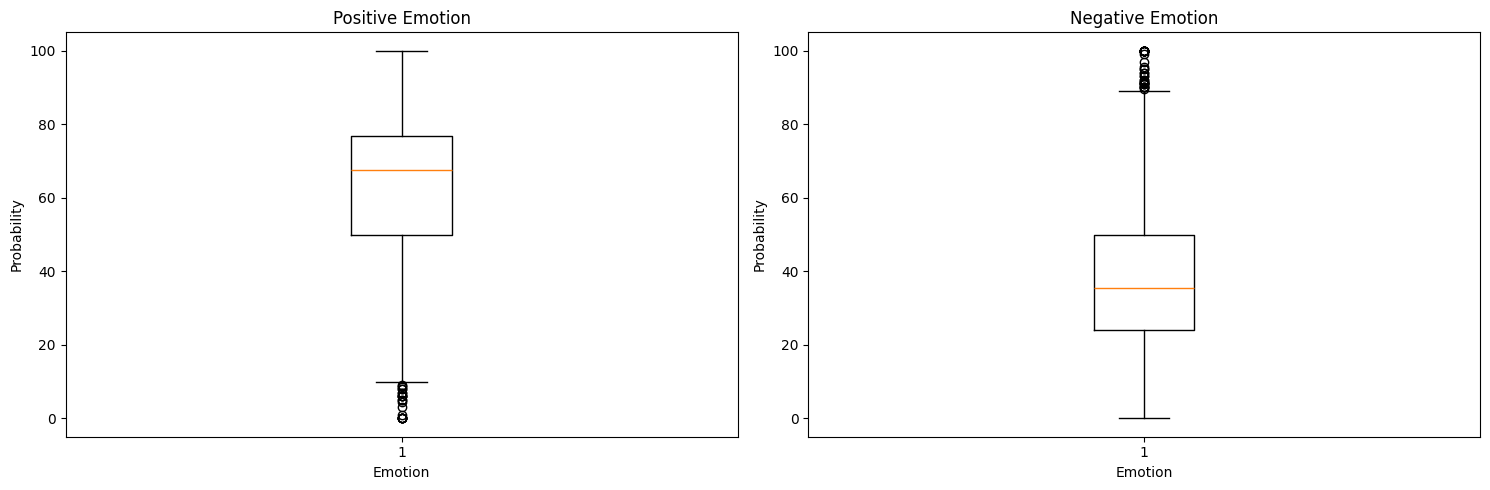

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plots Boxplot for Data 1
axs[0].boxplot(df_final['Positive Emotion'])
axs[0].set_title('Positive Emotion')
axs[0].set_xlabel('Emotion')
axs[0].set_ylabel('Probability')
# Plots Boxplot for Data 2
axs[1].boxplot(df_final['Negative Emotion'])
axs[1].set_title('Negative Emotion')
axs[1].set_xlabel('Emotion')
axs[1].set_ylabel('Probability')
# Adjusts layout
plt.tight_layout()
plt.show()

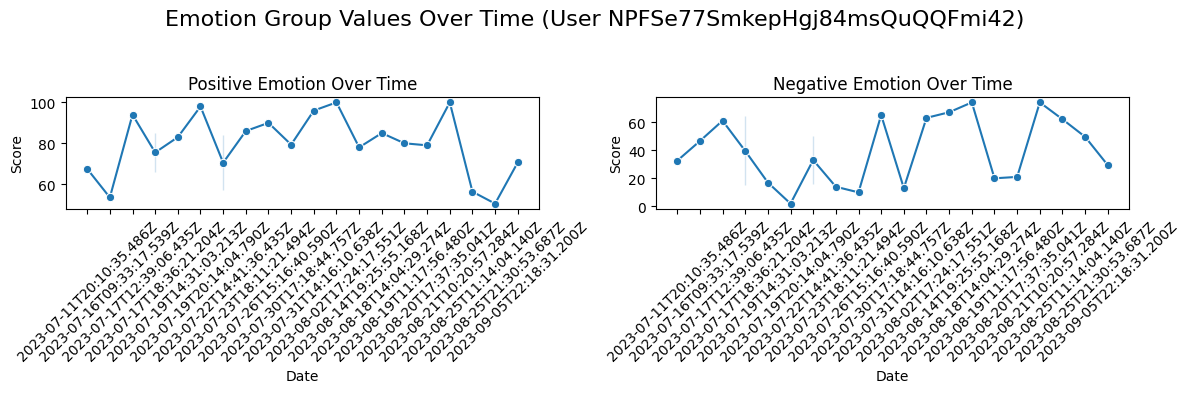

In [45]:
df_emotions_plot = df_final.sort_values(['User ID', 'Date/Time'])

# Plot emotional state transitions over time for a sample user
sample_user = df_emotions_plot['User ID'].unique()[46]
df_user = df_emotions_plot[df_emotions_plot['User ID'] == sample_user]

plt.figure(figsize=(12, 8))
for i, group in enumerate(emotions_labels):
    plt.subplot(3, 2, i + 1)
    sns.lineplot(x='Date/Time', y=group, data=df_user, marker='o')
    plt.title(f'{group} Over Time')
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle(f'Emotion Group Values Over Time (User {sample_user})', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Clustering
3 groups: underperforming, normal, overperforming

In [46]:
features = [
    'Age', 'Weight', 'Height', 'Tiredness', 'Calm', 'Nutrition',
    'Hydration', 'Performance', 'Positive Emotion', 'Negative Emotion'
]

In [47]:
# we want to group users at given times to estimate if they are underperorming or overperforming
df_athletes = df_final.groupby(['User ID', 'Date/Time']).agg({
    'Age': 'mean', 
    'Weight': 'mean',
    'Height': 'mean',
    'Tiredness': 'mean',
    'Calm': 'mean',
    'Nutrition': 'mean',
    'Hydration': 'mean',
    'Performance': 'mean',
    'Positive Emotion': 'mean', 
    'Negative Emotion': 'mean'
}).reset_index()

# View the grouped data
df_athletes.head()

,User ID,Date/Time,Age,Weight,Height,Tiredness,Calm,Nutrition,Hydration,Performance,Positive Emotion,Negative Emotion
0,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T18:04:02.727Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,73.633644,28.167148
1,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T19:02:57.742Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,100.000000,0.000000
2,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T19:19:57.842Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000
3,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-29T17:28:32.831Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000
4,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-09-05T22:27:45.510Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000


In [48]:
# Apply KMeans clustering (assume 3 clusters for this example)
kmeans = KMeans(n_clusters=3, random_state=42)
X_grouped = df_athletes[features]
df_athletes['Cluster'] = kmeans.fit_predict(X_grouped)

df_athletes.head()

/opt/anaconda3/envs/healthTech/lib/python3.9/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,User ID,Date/Time,Age,Weight,Height,Tiredness,Calm,Nutrition,Hydration,Performance,Positive Emotion,Negative Emotion,Cluster
0,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T18:04:02.727Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,73.633644,28.167148,0
1,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T19:02:57.742Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,100.000000,0.000000,2
2,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-27T19:19:57.842Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000,0
3,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-08-29T17:28:32.831Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000,0
4,00zbJz2Ez4WplqrL5NXHPXzsxSB3,2023-09-05T22:27:45.510Z,32.0,70.0,184.0,50.0,50.0,50.0,50.0,50.0,50.000000,50.000000,0


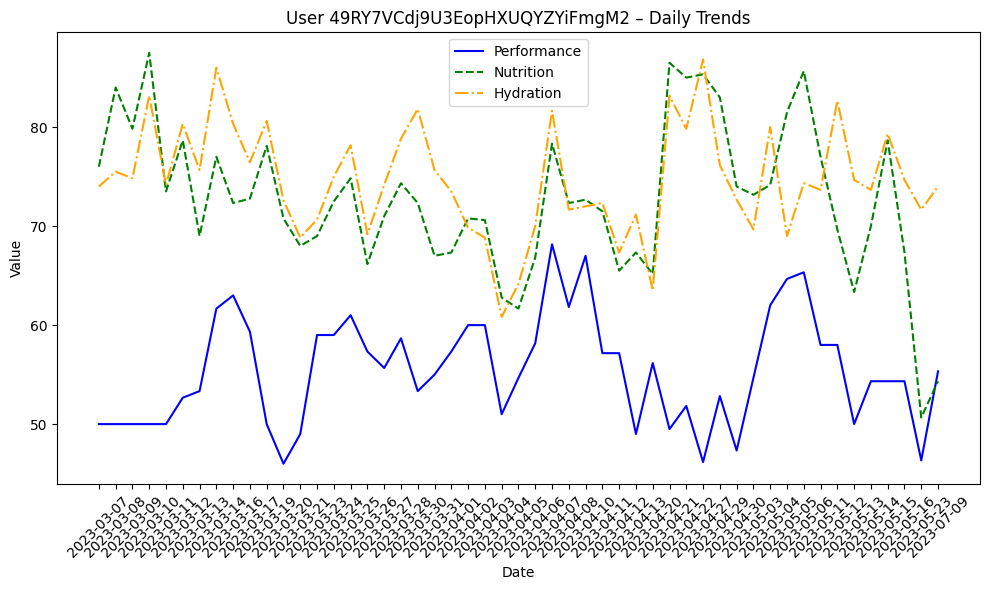

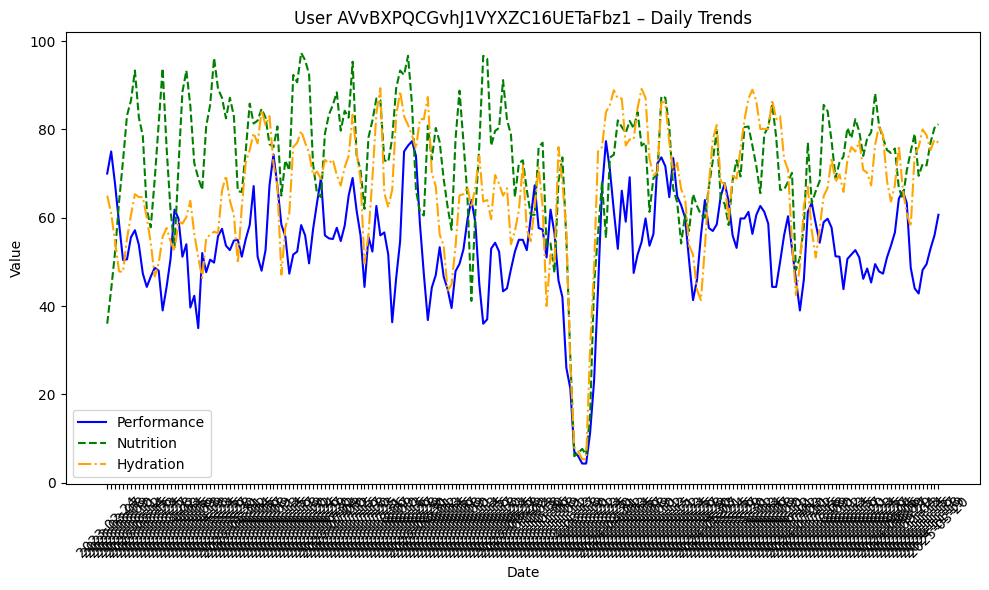

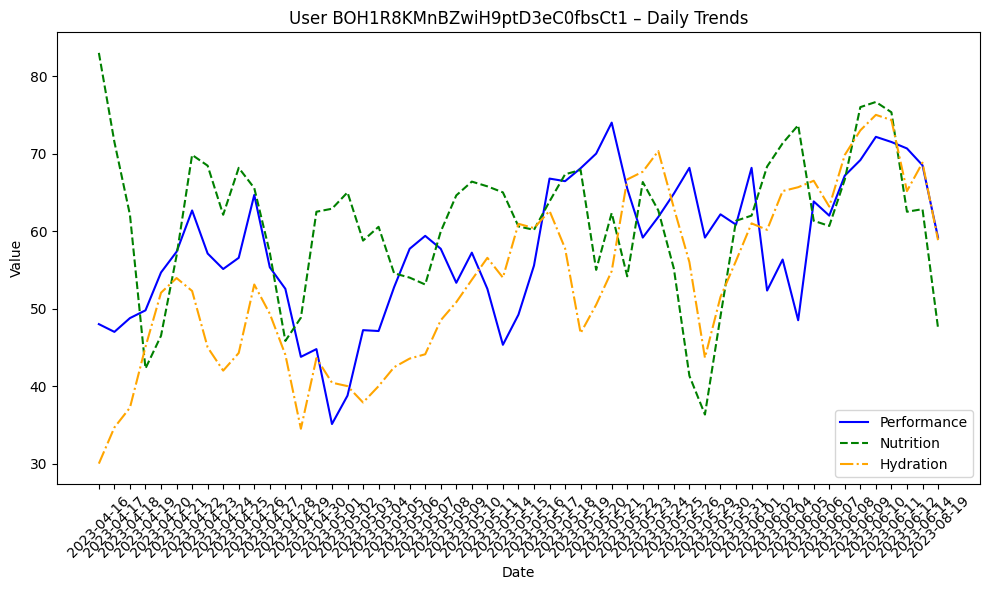

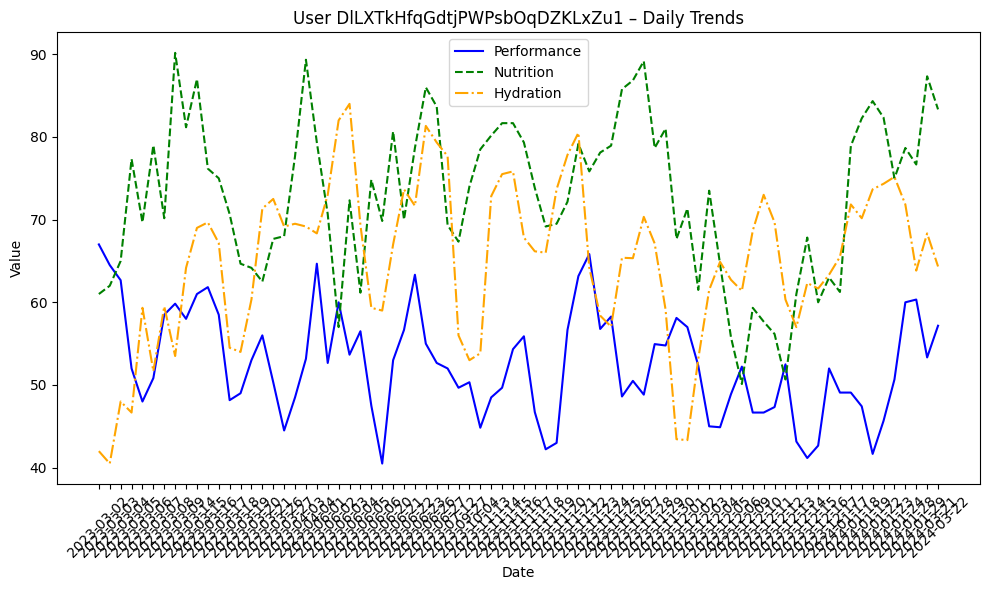

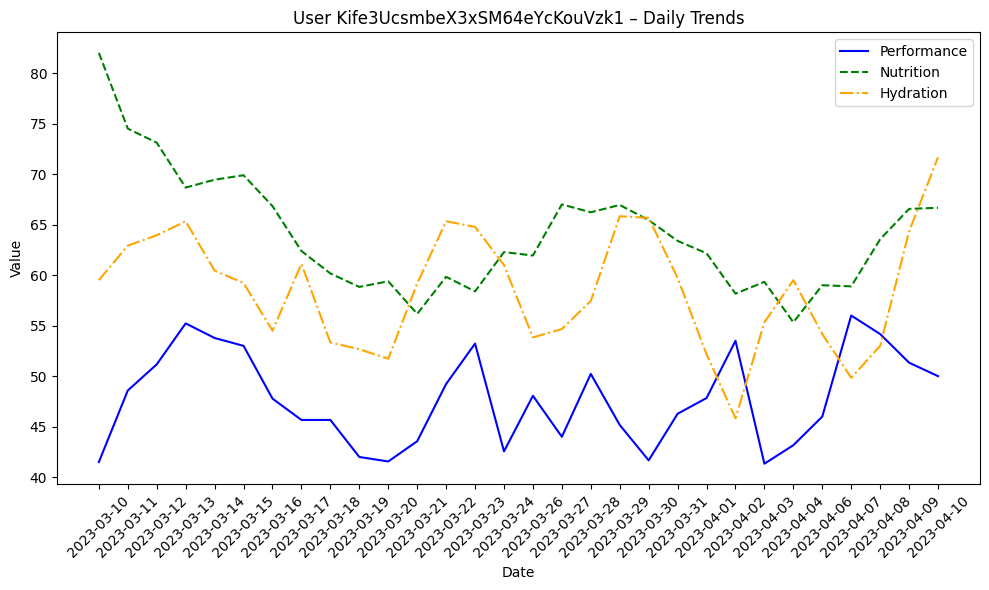

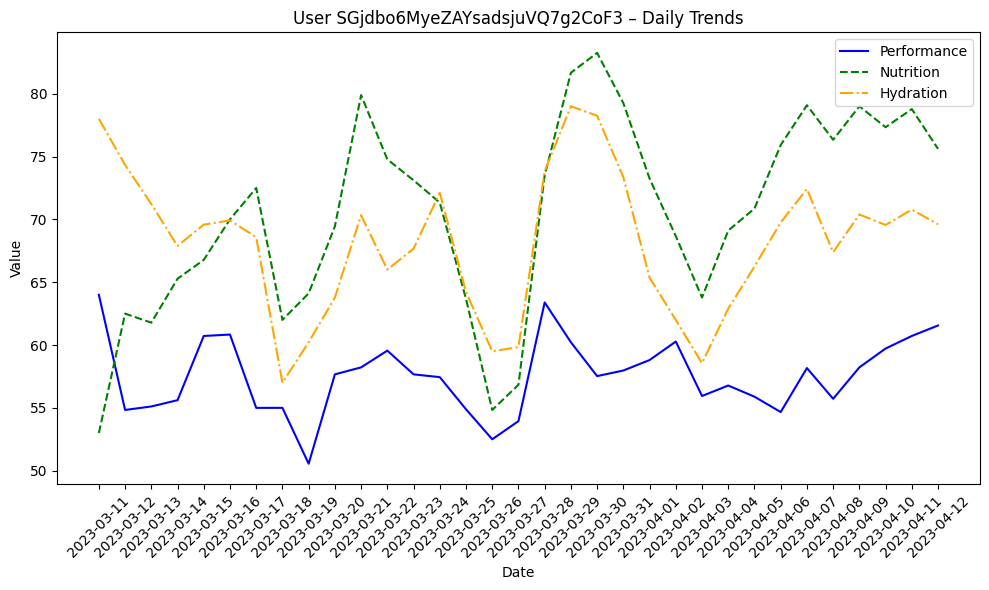

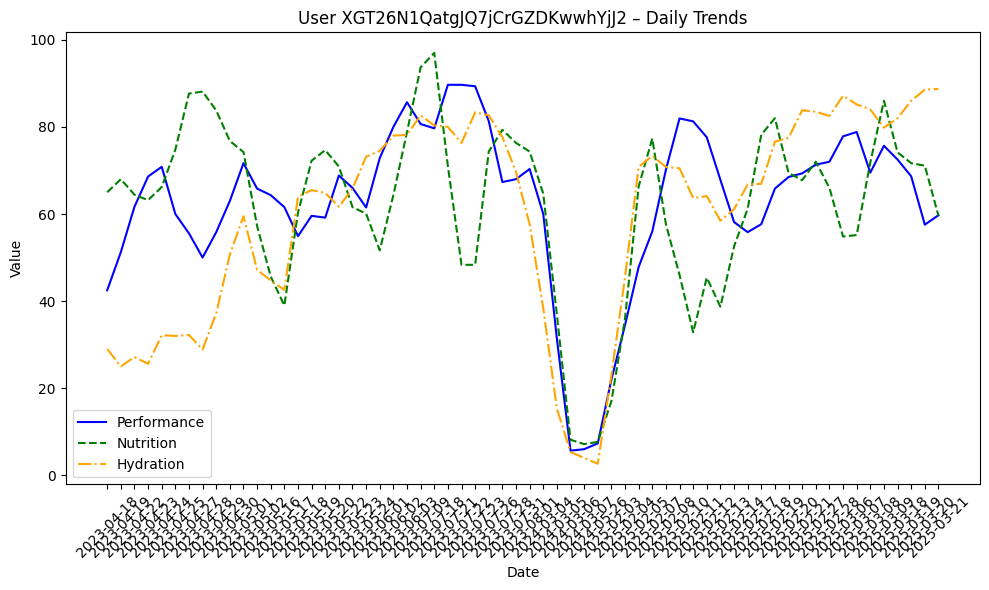

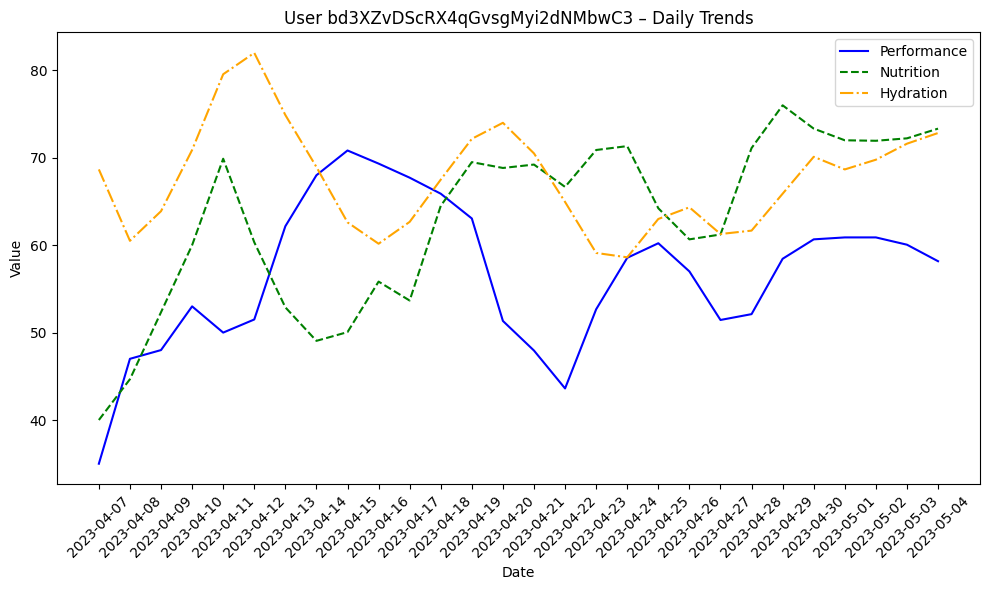

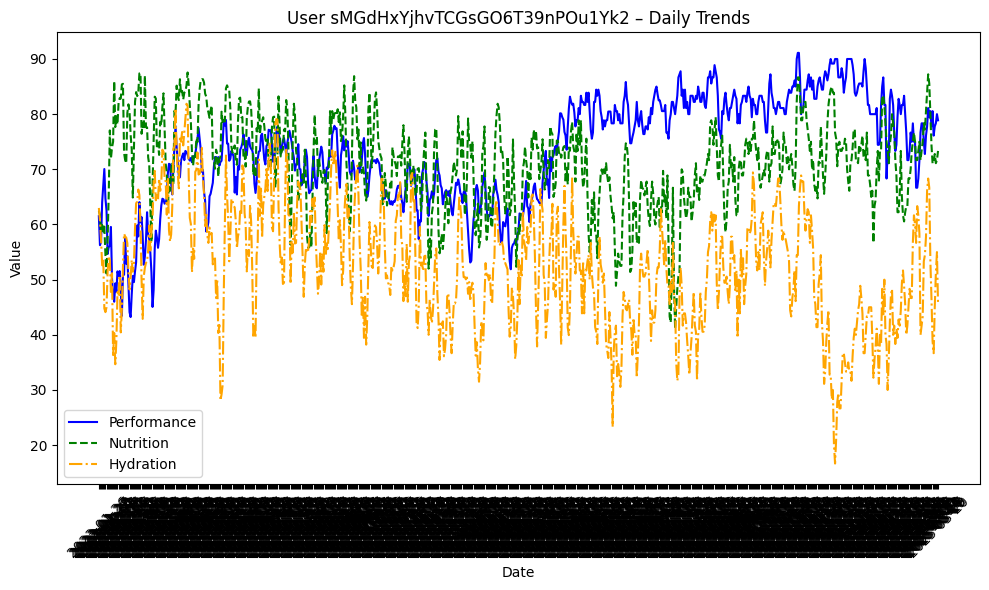

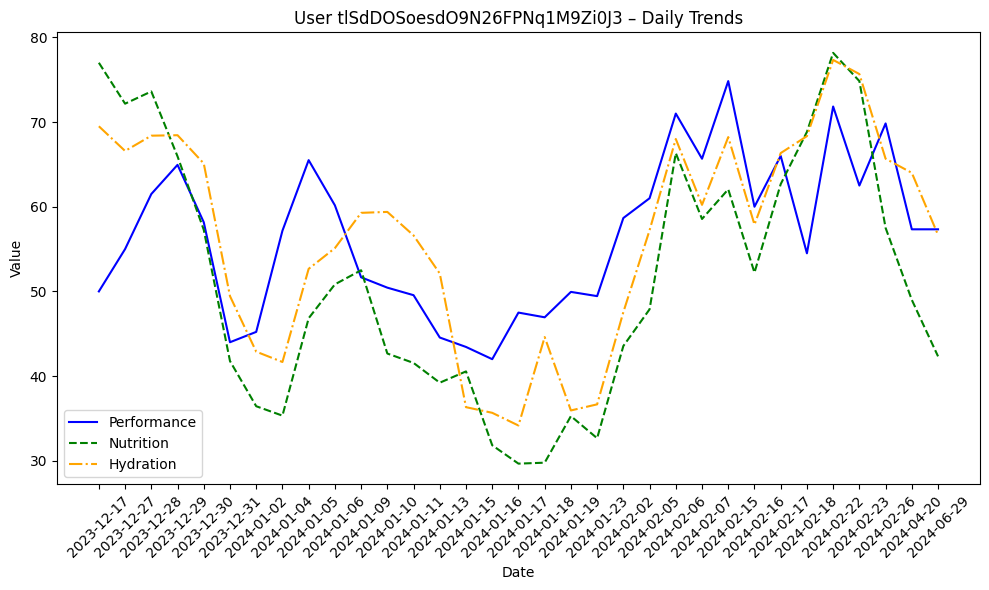

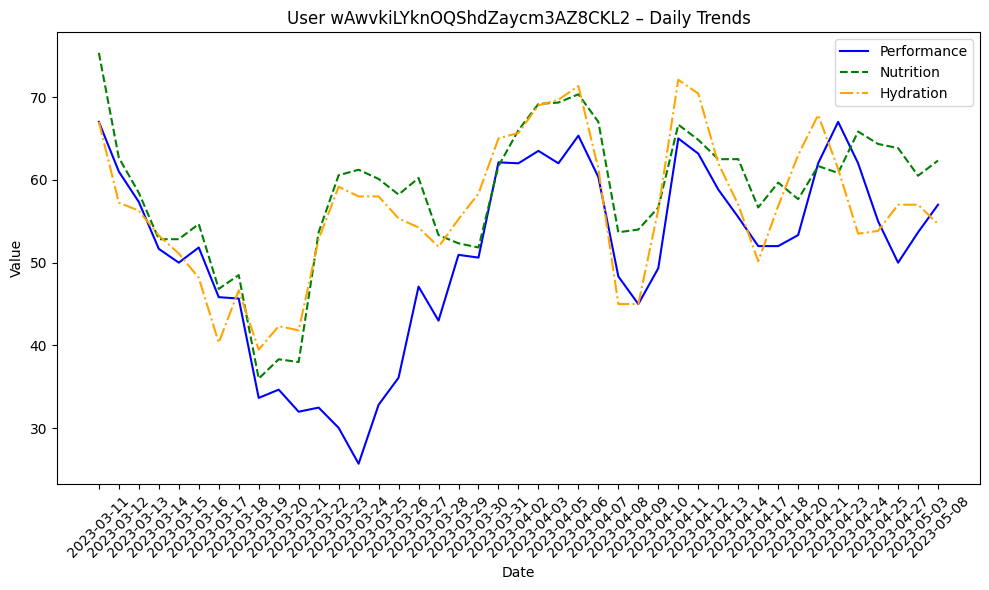

In [49]:
# Extract just the date part from timestamp string
df_athletes['Date'] = df_athletes['Date/Time'].str[:10]  # "YYYY-MM-DD"

# Loop through each user's group
for user_id, group in df_athletes.groupby('User ID'):
    if len(group) < 60:
        continue

    # Group by string date
    daily_group = group.groupby('Date')[['Performance', 'Nutrition', 'Hydration']].mean().reset_index()

    # Sort by string date
    daily_group = daily_group.sort_values('Date')

    # Smooth with rolling mean
    daily_group['Performance'] = daily_group['Performance'].rolling(window=3, min_periods=1).mean()
    daily_group['Nutrition'] = daily_group['Nutrition'].rolling(window=3, min_periods=1).mean()
    daily_group['Hydration'] = daily_group['Hydration'].rolling(window=3, min_periods=1).mean()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(daily_group['Date'], daily_group['Performance'], linestyle='-', color='blue', label='Performance')
    plt.plot(daily_group['Date'], daily_group['Nutrition'], linestyle='--', color='green', label='Nutrition')
    plt.plot(daily_group['Date'], daily_group['Hydration'], linestyle='-.', color='orange', label='Hydration')

    plt.title(f'User {user_id} – Daily Trends')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

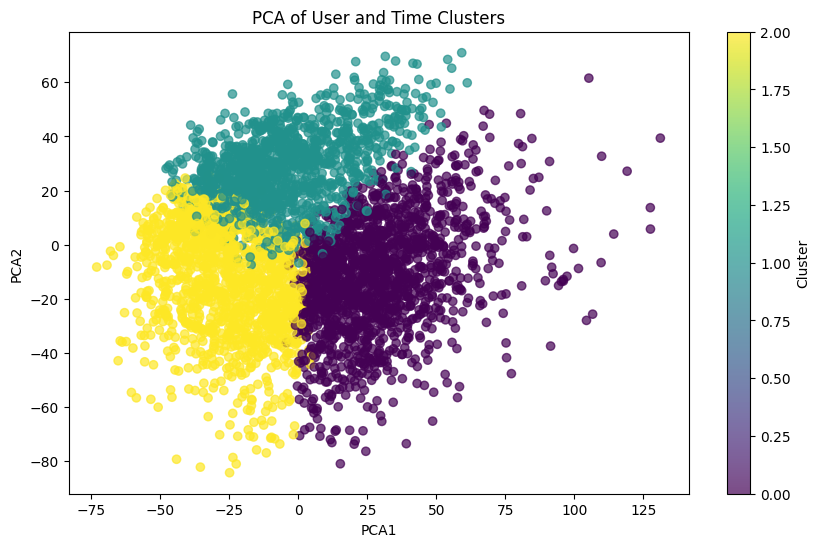

In [50]:
# Apply PCA to reduce data to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_grouped)

# Add the PCA results to the dataframe
df_athletes['PCA1'] = pca_result[:, 0]
df_athletes['PCA2'] = pca_result[:, 1]

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(df_athletes['PCA1'], df_athletes['PCA2'], c=df_athletes['Cluster'], cmap='viridis', alpha=0.7)
plt.title('PCA of User and Time Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')

plot_path = "plots/pca-nlp.png"
plt.savefig(plot_path, bbox_inches='tight')

plt.show()

In [51]:
graph_df = pd.read_csv('data/imputed_gcnn.csv').drop(columns=['Unnamed: 0'])
print(graph_df.shape)
print(graph_df.columns)

(5811, 39)
Index(['userid', 'timestamp', 'Tiredness', 'Calm', 'Nutrition', 'Hydration',
       'Performance', 'Concentrate', 'Happy', 'Determined', 'Excited',
       'Loving', 'Motivated', 'Powerful', 'Helpful', 'Lively', 'Peaceful',
       'Proud', 'Optimistic', 'Valued', 'Content', 'Hopeful', 'Confident',
       'Relieved', 'Annoyed', 'Nervous', 'Overwhelmed', 'Irritated', 'Anxious',
       'Afraid', 'Angry', 'Worried', 'Bored', 'Lonely', 'Weary',
       'Disappointed', 'Confused', 'Embarrassed', 'Sad'],
      dtype='object')


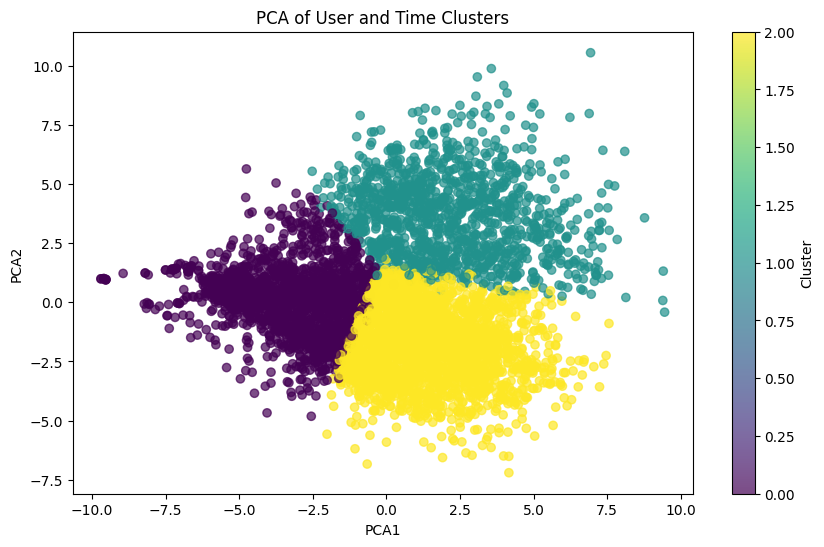

In [57]:
from sklearn.preprocessing import StandardScaler

gnn_features = [
    'Tiredness', 'Calm', 'Nutrition', 'Hydration', 'Performance', 'Concentrate',
    'Happy', 'Determined', 'Excited', 'Loving', 'Motivated', 'Powerful', 'Helpful',
    'Lively', 'Peaceful', 'Proud', 'Optimistic', 'Valued', 'Content', 'Hopeful',
    'Confident', 'Relieved', 'Annoyed', 'Nervous', 'Overwhelmed', 'Irritated',
    'Anxious', 'Afraid', 'Angry', 'Worried', 'Bored', 'Lonely', 'Weary',
    'Disappointed', 'Confused', 'Embarrassed', 'Sad'
]

meta_cols = ['userid', 'timestamp']

df_pca = graph_df[meta_cols + gnn_features].dropna(subset=gnn_features, how='all').copy()
df_pca[gnn_features] = df_pca[gnn_features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca[gnn_features])

# KMeans Clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df_pca['Cluster'] = cluster_labels

# Apply PCA to reduce data to 2D for visualization
pca_graph = PCA(n_components=2)
pca_result = pca_graph.fit_transform(X_scaled)

# Add the PCA results to the dataframe
df_pca['PCA1'] = pca_result[:, 0]
df_pca['PCA2'] = pca_result[:, 1]

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.title('PCA of User and Time Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')

plot_path = "plots/pca-gnn.png"
plt.savefig(plot_path, bbox_inches='tight')

plt.show()

### Define Cluster Labels
Classify clusters as Underperforming, Normal and Overperforming

In [59]:
# Compute average performance and emotion values per cluster
cluster_summary = df_pca.groupby('Cluster')[gnn_features].mean()

print(cluster_summary)

         Tiredness       Calm  Nutrition  Hydration  Performance  Concentrate  \
Cluster                                                                         
0        51.527189  53.629252  53.703883  50.369140    45.534364    47.750452   
1        57.589495  46.151192  59.611555  50.347092    48.847082    55.768672   
2        55.137620  68.309688  67.999879  57.550992    67.548051    69.632030   

             Happy  Determined    Excited     Loving  ...     Afraid  \
Cluster                                               ...              
0        31.294733   24.622029  28.290942  22.607421  ...  17.819105   
1        38.739319   37.955456  43.155388  43.132900  ...  47.545097   
2        62.598175   48.476355  61.383866  38.011355  ...  24.658684   

             Angry    Worried      Bored     Lonely      Weary  Disappointed  \
Cluster                                                                        
0        44.805338  23.174288  16.948304  22.587835  17.641722     17.749

### Plot emotion Devitation from Mean

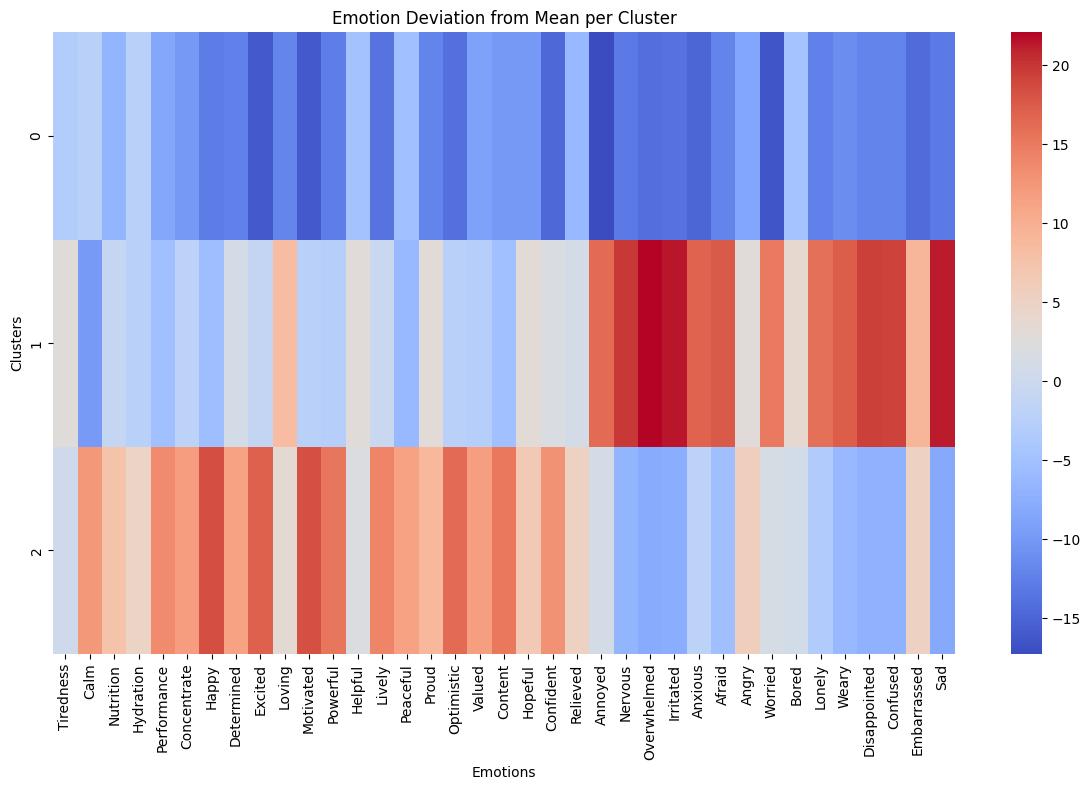

In [63]:
# Compute the overall mean across all clusters for each emotion
mean_values = cluster_summary.mean(axis=0)

# Compute the deviation from the mean for each emotion
deviation = cluster_summary - mean_values

plt.figure(figsize=(12, 8))
sns.heatmap(deviation, cmap='coolwarm', annot=False, fmt='.2f', cbar=True)

# Add labels and title
plt.title('Emotion Deviation from Mean per Cluster')
plt.xlabel('Emotions')
plt.ylabel('Clusters')

plot_path = "plots/heatmap-gnn.png"
plt.savefig(plot_path, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [54]:
# save cluster data generated by gnn model
df_pca.to_csv('data/gnn_cluster.csv', index=False)

In [55]:
# Compute average performance and emotion values per cluster
cluster_summary = df_athletes.groupby('Cluster')[['Performance', 'Positive Emotion', 'Negative Emotion']].mean()

# Display for manual inspection
print(cluster_summary)

# Rank clusters by performance
performance_ranks = cluster_summary['Performance'].rank().sort_values()
performance_labels = {
    performance_ranks.index[0]: "Underperforming",      # Mood (high) -> Performance (low)
    performance_ranks.index[1]: "Normal",               # 50% eveywhere
    performance_ranks.index[2]: "Overperforming"        # Mood (low) --> Performance (high)
}

# Assign labels to the data
df_athletes['Performance_Status'] = df_athletes['Cluster'].map(performance_labels)
df_athletes['Emotion_Status'] = df_athletes['Emotion_Status'] = np.where(df_athletes['Positive Emotion'] <= df_athletes['Negative Emotion'], 0, 1)

# Combine both
df_athletes['Cluster_Stage'] = df_athletes['Performance_Status'] + " | " + df_athletes['Emotion_Status'].astype(str)

         Performance  Positive Emotion  Negative Emotion
Cluster                                                 
0          52.051807         55.476251         48.397612
1          73.386569         61.204835         43.000120
2          70.241825         75.902273         25.118843


In [56]:
df_athletes.to_csv('data/complete_dataset.csv', index=False)
print(df_athletes.shape)

(4355, 19)
